In [2]:
!pip install transformers accelerate sentencepiece -q
!pip install konlpy -q
!apt-get install -y fonts-nanum > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 37.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
# 1. 데이터 로드 및 통합
claude_df = pd.read_csv("claude_summarized.csv", encoding="utf-8")
copilot_df = pd.read_csv("copilot_summarized.csv", encoding="cp949")
gpt4_df = pd.read_csv("GPT4_summarized.csv", encoding="cp949")
gemini_df = pd.read_csv("gemini_summarized.csv", encoding="cp949")

claude_df["source"] = "claude"
copilot_df["source"] = "copilot"
gpt4_df["source"] = "gpt4"
gemini_df["source"] = "gemini"

df_all = pd.concat([claude_df, copilot_df, gpt4_df, gemini_df], ignore_index=True)
print("총 샘플 수:", len(df_all))
print("레이블 분포:\n", df_all["source"].value_counts())

총 샘플 수: 2000
레이블 분포:
 source
claude     500
copilot    500
gpt4       500
gemini     500
Name: count, dtype: int64


In [5]:
# 2. 라벨 인코딩 및 분할
X = df_all["response"].astype(str)
y = df_all["source"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [6]:
# 3. 모델 및 토크나이저 설정
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 512

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
# 4. 모델 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [38]:
# 5. 학습 설정
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
PATIENCE = 3
EPOCHS = 8

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [39]:
# 6. 학습 루프
best_val_acc = 0
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Train Loss: {total_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model saved.")
    else:
        patience_counter += 1
        print(f"\u23f3 Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

[Epoch 1] Training: 100%|██████████| 88/88 [02:04<00:00,  1.42s/it]


Train Loss: 15.1462
Validation Accuracy: 0.8133
Best model saved.


[Epoch 2] Training: 100%|██████████| 88/88 [02:04<00:00,  1.41s/it]


Train Loss: 10.6564
Validation Accuracy: 0.6933
⏳ Patience: 1/3


[Epoch 3] Training: 100%|██████████| 88/88 [02:04<00:00,  1.41s/it]


Train Loss: 6.8141
Validation Accuracy: 0.7833
⏳ Patience: 2/3


[Epoch 4] Training: 100%|██████████| 88/88 [02:04<00:00,  1.41s/it]


Train Loss: 4.3780
Validation Accuracy: 0.7033
⏳ Patience: 3/3
Early stopping triggered.



Classification Report:
              precision    recall  f1-score   support

      claude       0.76      0.83      0.79        75
     copilot       0.86      0.72      0.78        75
      gemini       0.81      0.95      0.87        75
        gpt4       0.82      0.73      0.77        75

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.80       300
weighted avg       0.81      0.81      0.80       300


Precision / Recall / F1-score (요약):
              precision    recall  f1-score
claude         0.756098  0.826667  0.789809
copilot        0.857143  0.720000  0.782609
gemini         0.806818  0.946667  0.871166
gpt4           0.820896  0.733333  0.774648
accuracy       0.806667  0.806667  0.806667
macro avg      0.810239  0.806667  0.804558
weighted avg   0.810239  0.806667  0.804558


<Figure size 600x600 with 0 Axes>

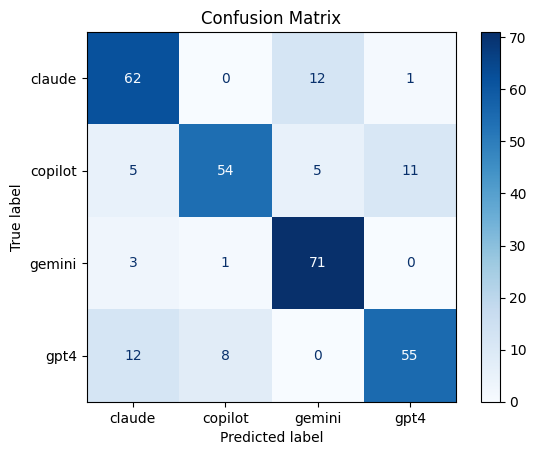

In [40]:
# 7. 테스트 평가 및 리포트
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

true_labels = []
predicted_labels = []
test_loader = DataLoader(test_dataset, batch_size=8)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

print("\nClassification Report:")
target_names = list(label_map.keys())
print(classification_report(true_labels, predicted_labels, target_names=target_names))

report_df = pd.DataFrame(classification_report(
    true_labels, predicted_labels, target_names=target_names, output_dict=True
)).transpose()

print("\nPrecision / Recall / F1-score (요약):")
print(report_df[['precision', 'recall', 'f1-score']])

# 혼동 행렬 시각화
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [19]:
!mkdir -p /content/drive/MyDrive/model_checkpoints


In [41]:
!cp best_model.pt /content/drive/MyDrive/model_checkpoints/best_model_kc3.pt


In [54]:
# KLUE-RoBERTa + KcELECTRA 앙상블 텍스트 분류기

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import pandas as pd

df = pd.read_csv("/content/test_data.csv")
df.columns = ["text", "label"]
label_list = sorted(df["label"].unique().tolist())
label_map = {label: i for i, label in enumerate(label_list)}
idx_to_label = {i: label for label, i in label_map.items()}
df["label_id"] = df["label"].map(label_map)

tokenizer_roberta = AutoTokenizer.from_pretrained("klue/roberta-base")
tokenizer_electra = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

class EnsembleDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc1 = tokenizer_roberta(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        enc2 = tokenizer_electra(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

        return {
            "input_ids1": enc1["input_ids"].squeeze(0),
            "attention_mask1": enc1["attention_mask"].squeeze(0),
            "input_ids2": enc2["input_ids"].squeeze(0),
            "attention_mask2": enc2["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

ensemble_dataset = EnsembleDataset(df["text"], df["label_id"])
test_loader = DataLoader(ensemble_dataset, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = AutoModelForSequenceClassification.from_pretrained("klue/roberta-base", num_labels=len(label_list))
model1.load_state_dict(torch.load("/content/drive/MyDrive/model_checkpoints/best_model.pt"))
model1.to(device).eval()

model2 = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=len(label_list))
model2.load_state_dict(torch.load("/content/drive/MyDrive/model_checkpoints/best_model_kc3.pt"))
model2.to(device).eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        ids1 = batch["input_ids1"].to(device)
        mask1 = batch["attention_mask1"].to(device)
        ids2 = batch["input_ids2"].to(device)
        mask2 = batch["attention_mask2"].to(device)
        labels = batch["labels"].to(device)

        logits1 = model1(input_ids=ids1, attention_mask=mask1).logits
        logits2 = model2(input_ids=ids2, attention_mask=mask2).logits

        final_logits = (logits1 + logits2) / 2  # soft voting
        preds = torch.argmax(final_logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

target_names = label_list
print("\n📋 앙상블 모델 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=target_names))

# 요약표 출력
report_df = pd.DataFrame(classification_report(
    true_labels, pred_labels, target_names=target_names, output_dict=True
)).transpose()

print("\nPrecision / Recall / F1-score (요약):")
print(report_df[['precision', 'recall', 'f1-score']])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📋 앙상블 모델 Classification Report:
              precision    recall  f1-score   support

      claude       0.85      0.93      0.89        75
     copilot       0.80      0.87      0.83        75
      gemini       0.98      0.80      0.88        75
        gpt4       0.88      0.89      0.89        75

    accuracy                           0.87       300
   macro avg       0.88      0.87      0.87       300
weighted avg       0.88      0.87      0.87       300


Precision / Recall / F1-score (요약):
              precision    recall  f1-score
claude         0.853659  0.933333  0.891720
copilot        0.802469  0.866667  0.833333
gemini         0.983607  0.800000  0.882353
gpt4           0.881579  0.893333  0.887417
accuracy       0.873333  0.873333  0.873333
macro avg      0.880328  0.873333  0.873706
weighted avg   0.880328  0.873333  0.873706


In [29]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [57]:
# 앙상블 분류기 Streamlit 앱 (RoBERTa + KcELECTRA)
%%writefile app.py
import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델 경로 및 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 4
LABEL_MAP = {0: "claude", 1: "copilot", 2: "gemini", 3: "gpt4"}

# 모델 및 토크나이저 로드
def load_model_and_tokenizer(model_name, model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

roberta_model, roberta_tokenizer = load_model_and_tokenizer("klue/roberta-base", "/content/drive/MyDrive/model_checkpoints/best_model.pt")
electra_model, electra_tokenizer = load_model_and_tokenizer("beomi/KcELECTRA-base", "/content/drive/MyDrive/model_checkpoints/best_model_kc3.pt")

# 예측 함수 (앙상블)
def predict_ensemble(text):
    enc1 = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    enc2 = electra_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    with torch.no_grad():
        logits1 = roberta_model(input_ids=enc1["input_ids"].to(DEVICE), attention_mask=enc1["attention_mask"].to(DEVICE)).logits
        logits2 = electra_model(input_ids=enc2["input_ids"].to(DEVICE), attention_mask=enc2["attention_mask"].to(DEVICE)).logits

        final_logits = (logits1 + logits2) / 2
        pred = torch.argmax(final_logits, dim=1).item()

    return LABEL_MAP[pred]

# Streamlit UI 설정
st.title("🧠 한국어 생성 모델 분류기")
st.markdown("""
이 앱은 입력된 텍스트가 Claude, Copilot, GPT-4, Gemini 중 어떤 모델이 생성했는지를 예측합니다.
두 개의 사전학습 모델(RoBERTa + KcELECTRA)을 앙상블하여 예측 성능을 높였습니다.
""")

user_input = st.text_area("✍️ 텍스트를 입력하세요:", height=200)

if st.button("예측하기"):
    if not user_input.strip():
        st.warning("⚠️ 텍스트를 입력해주세요.")
    else:
        with st.spinner("예측 중..."):
            prediction = predict_ensemble(user_input)
        st.success(f"✅ 예측된 생성 모델: **{prediction.upper()}**")


Overwriting app.py


In [58]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# "Password/Enpoint IP for localtunnel is:" 우측에 xx.xxx.xx.xxx 혹은 xx.xxx.xxx.xxx 형식의 숫자가 나온다.

Password/Enpoint IP for localtunnel is: 34.105.64.12


In [59]:
!npm install localtunnel
# 5
!streamlit run app.py &>/content/logs.txt &
# 6
!npx localtunnel --port 8501

# "your url is:" 우측에 사이트 주소가 생성된다.

⠙⠹⠸⠼
up to date, audited 23 packages in 649ms
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠼⠙your url is: https://five-fans-bake.loca.lt
^C
